# Understanding Sovereign Default Events Using a Machine Learning Approach

Developed by: Michael Arias (2024), Pontificia Universidad Javeriana

## Libraries

On this section, the packages required to develop the exercise are loaded.

In [1]:
from imblearn.over_sampling import RandomOverSampler, SMOTE, ADASYN
from imblearn.pipeline import make_pipeline
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from sklearn.datasets import make_classification
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, classification_report
from sklearn.metrics import roc_curve, roc_auc_score, auc
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns
import statsmodels.api as sm
from sklearn.datasets import load_iris
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import export_graphviz
import pydot
from sklearn.tree import plot_tree
from sklearn.feature_selection import RFE
from imblearn.pipeline import Pipeline
from imblearn.combine import SMOTEENN
from imblearn.under_sampling import RandomUnderSampler
from sklearn.preprocessing import MultiLabelBinarizer

## Data Understanding

The file "IA Model 2" contains the data from the World Bank and the Bank of Canada (Sovereign Default)
- World Bank, World Development Indicators: https://databank.worldbank.org/source/world-development-indicators
- Bank of Canada, Sovereign Default Database: https://www.bankofcanada.ca/2023/07/staff-analytical-note-2023-10/


In [2]:
#Import the data
df = pd.read_excel('C:/Users/User/Desktop/Michael/Thesis/IA Model 2.xlsx')

In [3]:
#Copy the original dataframe
df_2 = df

In [4]:
df.head()

,Country Name,Series Name,1960,1961,1962,1963,1964,1965,1966,1967,...,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021
0,Afghanistan,"Charges for the use of intellectual property, ...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.073803e+07,1.094402e+07,107890.109069,242475.541834,36802.950000,180660.399928,2.402431e+06,4.778791e+06,6.111814e+06,NaN
1,Afghanistan,"Charges for the use of intellectual property, ...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,463662.430554,12809.260000,NaN,NaN,NaN,5.555671e+03,3.351955e+02,NaN
2,Afghanistan,"Communications, computer, etc. (% of service e...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,7.235127e+01,4.854783e+01,64.918791,72.072917,67.598328,69.968519,7.083196e+01,7.192168e+01,7.802863e+01,NaN
3,Afghanistan,"Communications, computer, etc. (% of service i...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2.951479e+01,1.955508e+01,24.480702,13.177998,10.985595,9.260279,1.351060e+01,1.206885e+01,1.217666e+01,NaN
4,Afghanistan,Current account balance (% of GDP),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-2.587068e+01,-2.529006e+01,-15.772420,-21.912657,-14.950195,-18.955961,-2.158527e+01,-2.017046e+01,-1.571830e+01,NaN


In [5]:
df['Country Name'].unique()

array(['Afghanistan', 'Albania', 'Algeria', 'American Samoa', 'Andorra',
       'Angola', 'Antigua and Barbuda', 'Argentina', 'Armenia', 'Aruba',
       'Australia', 'Austria', 'Azerbaijan', 'Bahamas, The', 'Bahrain',
       'Bangladesh', 'Barbados', 'Belarus', 'Belgium', 'Belize', 'Benin',
       'Bermuda', 'Bhutan', 'Bolivia', 'Bosnia and Herzegovina',
       'Botswana', 'Brazil', 'British Virgin Islands',
       'Brunei Darussalam', 'Bulgaria', 'Burkina Faso', 'Burundi',
       'Cabo Verde', 'Cambodia', 'Cameroon', 'Canada', 'Cayman Islands',
       'Central African Republic', 'Chad', 'Channel Islands', 'Chile',
       'China', 'Colombia', 'Comoros', 'Congo, Dem. Rep.', 'Congo, Rep.',
       'Costa Rica', "Cote d'Ivoire", 'Croatia', 'Cuba', 'Curacao',
       'Cyprus', 'Czechia', 'Denmark', 'Djibouti', 'Dominica',
       'Dominican Republic', 'Ecuador', 'Egypt, Arab Rep.', 'El Salvador',
       'Equatorial Guinea', 'Eritrea', 'Estonia', 'Eswatini', 'Ethiopia',
       'Faroe Islands',

In the first column are the countries, while in the second column is the information related to the different variables present on the dataset, while on the remaining columns is the information from 1960 - 2021. Is necesary to perform different transformations on the dataframe.

In [6]:
# Pivot and melt the table
df = df.melt(id_vars=['Country Name', 'Series Name'], var_name='Year', value_name='Value')
df = df.pivot_table(index=['Country Name', 'Year'], columns='Series Name', values='Value').reset_index()
df = df.rename(columns={'Country Name': 'C'})

In [7]:
# Calcular la cantidad de valores nulos por columna
null_counts = df.isnull().sum()

print(null_counts)

Series Name
C                                                                                                      0
Year                                                                                                   0
ARI treatment (% of children under 5 taken to a health provider)                                   17043
Access to clean fuels and technologies for cooking (% of population)                               12270
Access to clean fuels and technologies for cooking, rural (% of rural population)                  12270
                                                                                                   ...  
Women who believe a husband is justified in beating his wife when she neglects the children (%)    17305
Women who believe a husband is justified in beating his wife when she refuses sex with him (%)     17309
Women who were first married by age 18 (% of women ages 20-24)                                     17081
Women's share of population ages 15+ living

In [8]:
#Group the table by the Country and the Year
df = df.groupby(['C', 'Year']).sum().reset_index()

In [9]:
df.describe()

Series Name,Year,ARI treatment (% of children under 5 taken to a health provider),Access to clean fuels and technologies for cooking (% of population),"Access to clean fuels and technologies for cooking, rural (% of rural population)","Access to clean fuels and technologies for cooking, urban (% of urban population)",Access to electricity (% of population),"Access to electricity, rural (% of rural population)","Access to electricity, urban (% of urban population)",Account ownership at a financial institution or with a mobile-money-service provider (% of population ages 15+),"Account ownership at a financial institution or with a mobile-money-service provider, female (% of population ages 15+)",...,"Women participating in the three decisions (own health care, major household purchases, and visiting family) (% of women age 15-49)",Women who believe a husband is justified in beating his wife (any of five reasons) (%),Women who believe a husband is justified in beating his wife when she argues with him (%),Women who believe a husband is justified in beating his wife when she burns the food (%),Women who believe a husband is justified in beating his wife when she goes out without telling him (%),Women who believe a husband is justified in beating his wife when she neglects the children (%),Women who believe a husband is justified in beating his wife when she refuses sex with him (%),Women who were first married by age 18 (% of women ages 20-24),Women's share of population ages 15+ living with HIV (%),Young people (ages 15-24) newly infected with HIV
count,17484.000000,17484.000000,17484.000000,17484.000000,17484.000000,17484.000000,17484.000000,17484.000000,17484.000000,17484.000000,...,17484.000000,17484.000000,17484.000000,17484.000000,17484.000000,17484.000000,17484.000000,17484.000000,17484.000000,17484.000000
mean,1990.500000,1.451314,18.483166,15.730068,21.529052,33.940275,30.205809,37.876456,2.116177,2.003002,...,0.491792,0.423439,0.245813,0.142622,0.279433,0.316466,0.201356,0.672478,13.982460,2429.415466
std,17.896042,9.492464,35.187651,33.067950,38.030953,44.003861,42.758783,46.135910,12.228475,11.837593,...,5.346830,4.737724,3.042563,1.902977,3.355766,3.605943,2.605211,5.085780,21.206507,33370.280162
min,1960.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1975.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1990.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,2006.000000,0.000000,9.402446,1.900000,24.754126,93.355749,84.061795,98.487198,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,27.900000,0.000000
max,2021.000000,97.500000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,...,92.800000,92.100000,77.600000,64.500000,82.700000,81.000000,73.500000,83.500000,89.700000,1000000.000000


In [10]:
# Select the columns
df_selected = df.iloc[:, 2:]

# Correl Matrix
correlation_matrix = df_selected.corr()

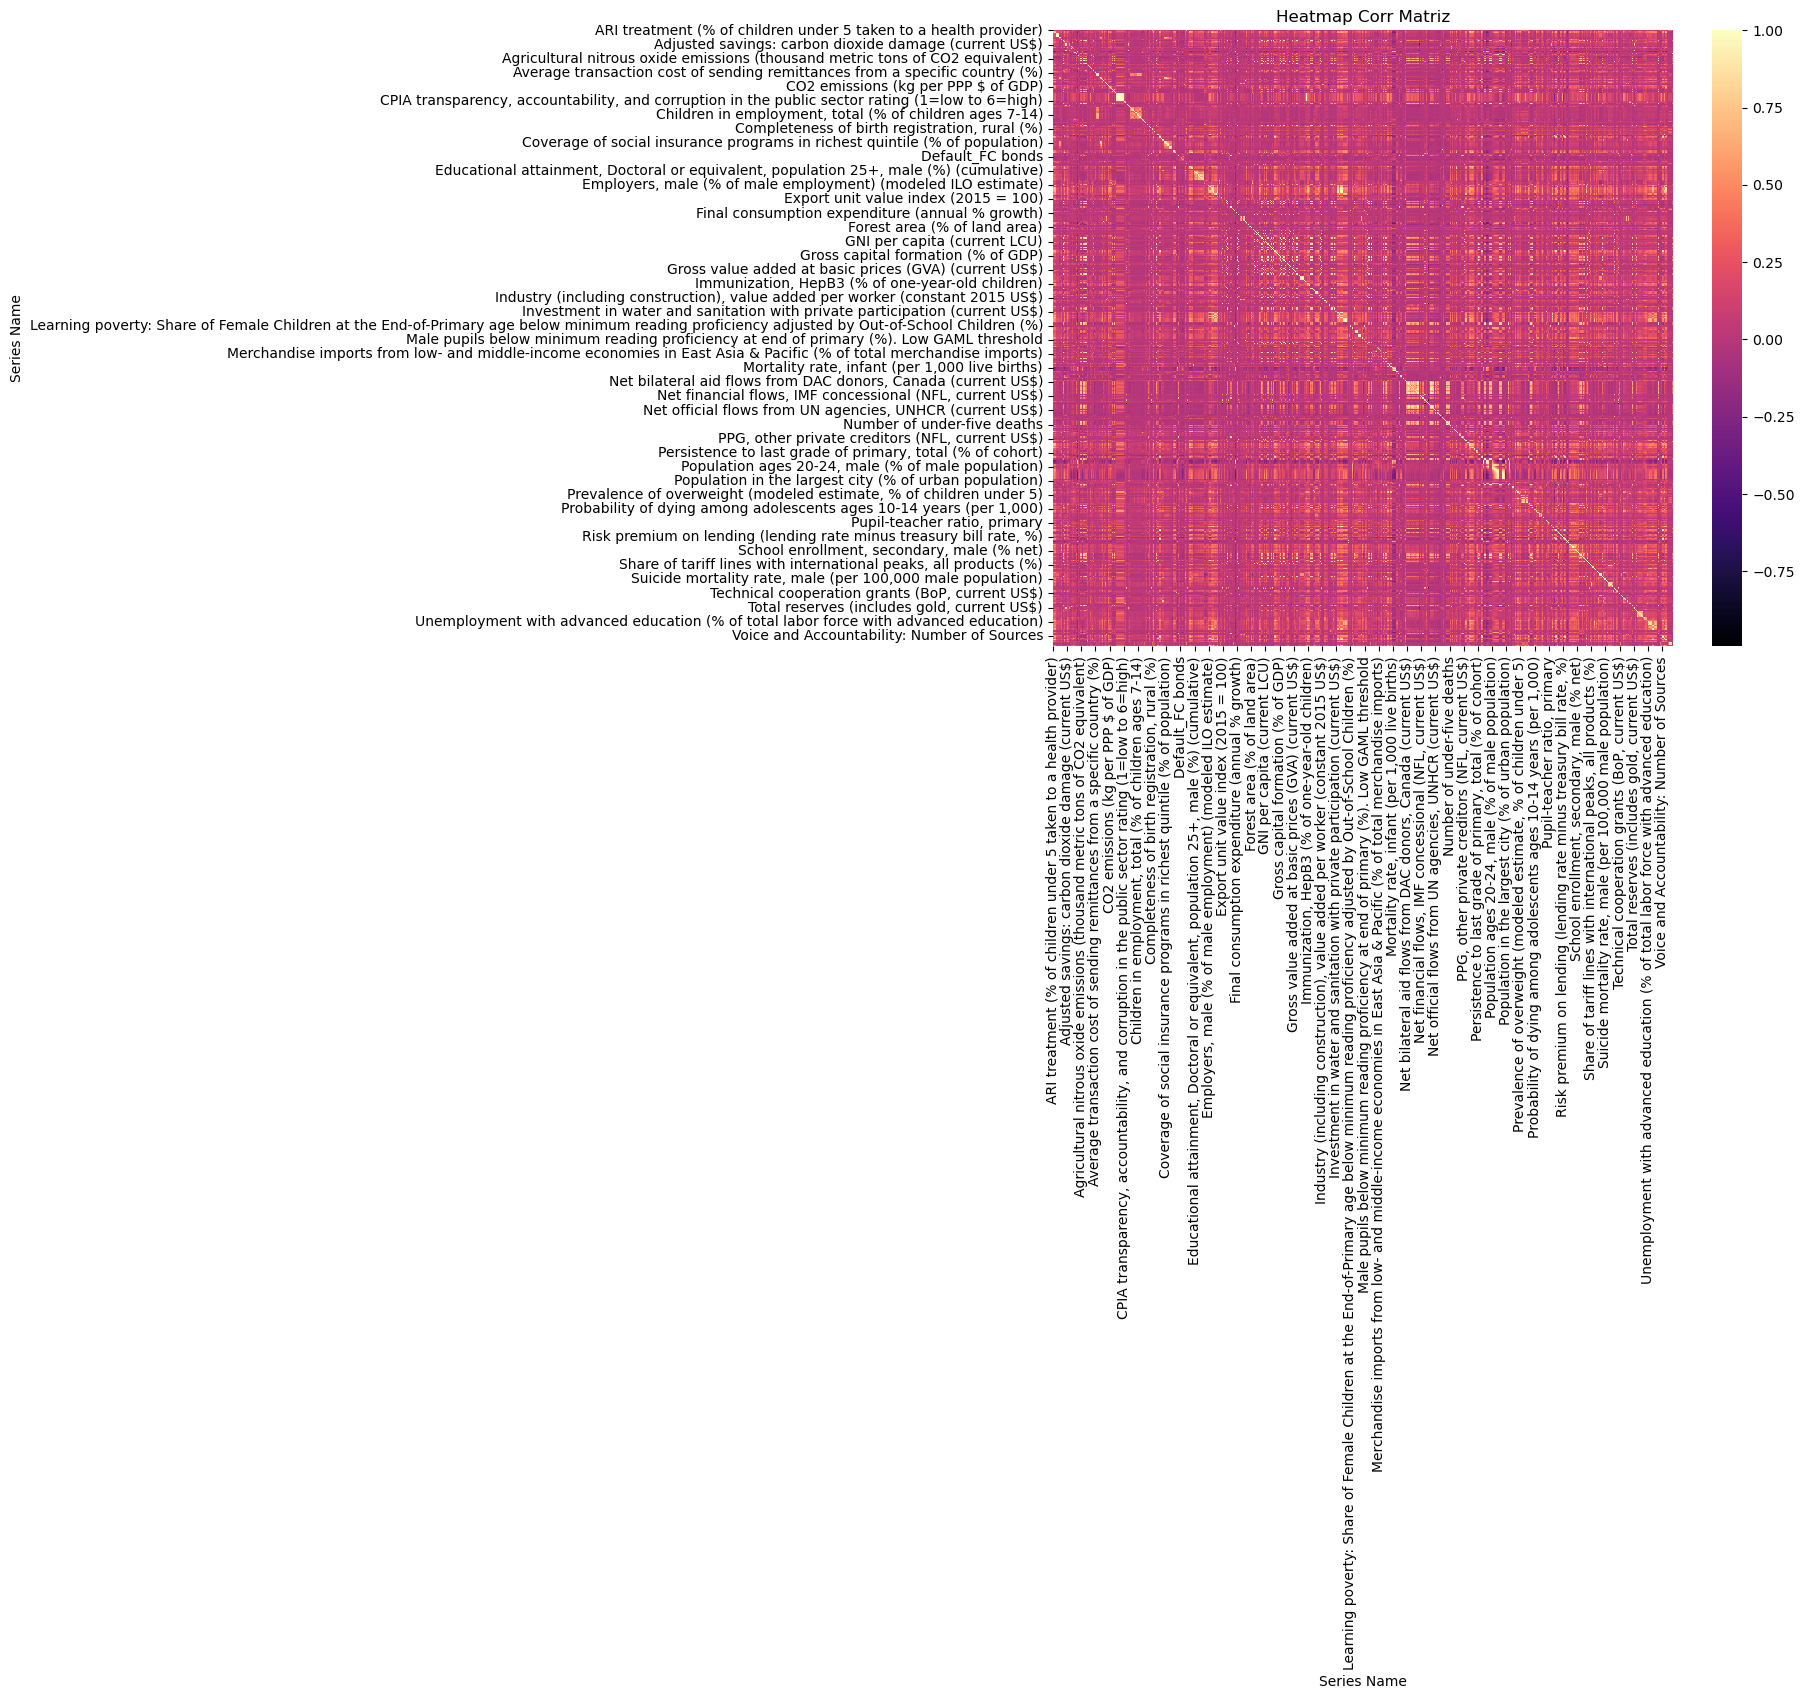

In [11]:
# Create the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=None, cmap='magma', center=0)

# Format
plt.title('Heatmap Corr Matriz')
plt.show()

c:\Users\User\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\User\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


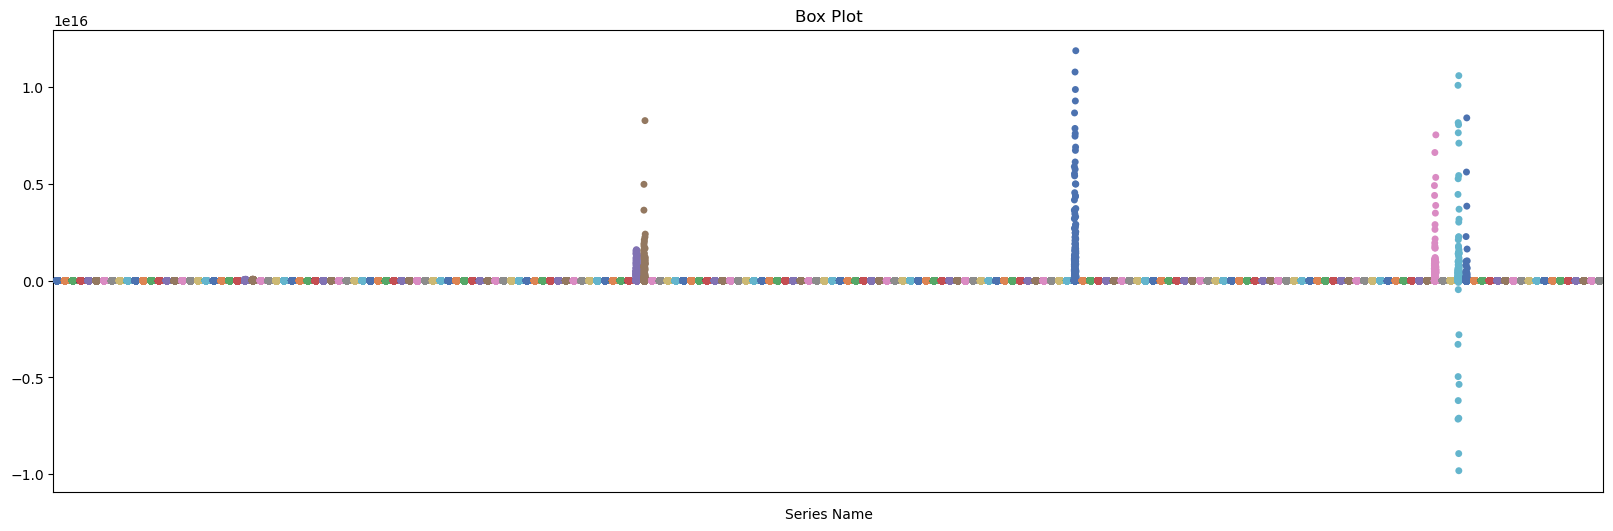

In [141]:
#Stripplot
plt.figure(figsize=(20, 6))
stripplot = sns.stripplot(data=df.iloc[:, 2:200], dodge=False, palette="deep")
plt.title('Box Plot')

# Rmove the names on x axis
stripplot.set_xticklabels([])
stripplot.tick_params(axis='x', bottom=False)
plt.show()

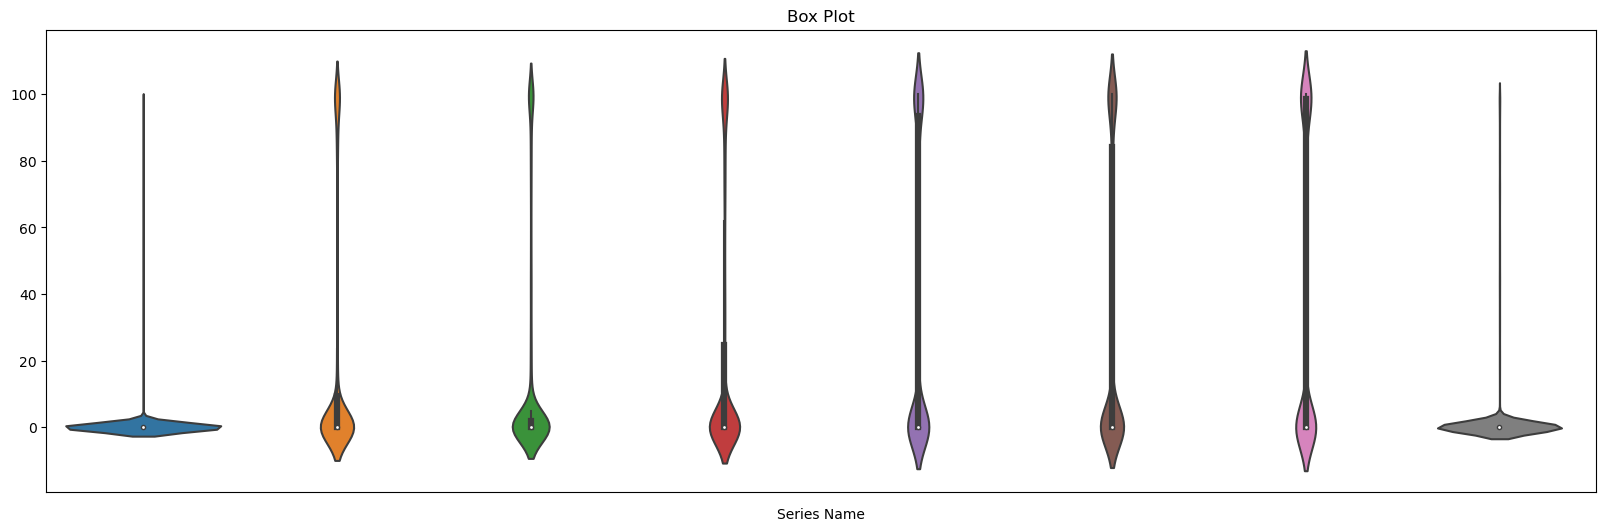

In [84]:
# Violin plot
plt.figure(figsize=(20, 6))
boxplot = sns.violinplot(data=df.iloc[:, 2:10]) #Just a sample of the total dataframe
plt.title('Box Plot')

# Rmove the names on x axis
boxplot.set_xticklabels([])
boxplot.tick_params(axis='x', bottom=False)
plt.show()

The data presents outliers and a some features are highly correlated. There is a need to scale some variables and input the missing values with the average for each country for each variable. Also, there is a need to remove highly correlated variables.

On the other hand, there are different types of variables represented on different scales: %, US, scales, per 'n' population, and more. Find more details on: https://databank.worldbank.org/metadataglossary/World-Development-Indicators/series

### Check outliers for variables expresed on %

In [98]:
# Filter columns only for %
filtered_columns = [col for col in df.columns if '%' in col]
df_filtered = df[filtered_columns]

c:\Users\User\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\User\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


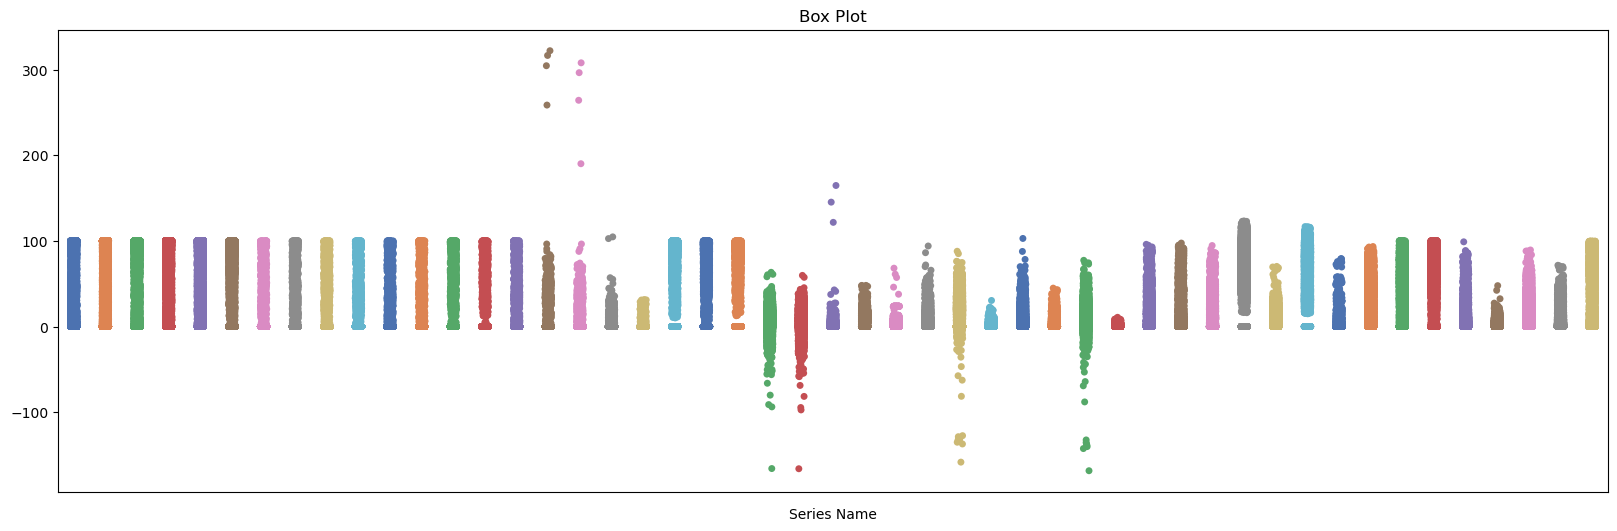

In [139]:
#Stripplot
plt.figure(figsize=(20, 6))
stripplot = sns.stripplot(data=df_filtered.iloc[:, 1:50], dodge=False, palette="deep")
plt.title('Box Plot')

# Rmove the names on x axis
stripplot.set_xticklabels([])
stripplot.tick_params(axis='x', bottom=False)
plt.show()

### Check outliers for variables expresed on US $ dollars

In [142]:
# Filter columns only for %
filtered_columns = [col for col in df.columns if 'US$' in col]
df_filtered = df[filtered_columns]

c:\Users\User\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\User\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


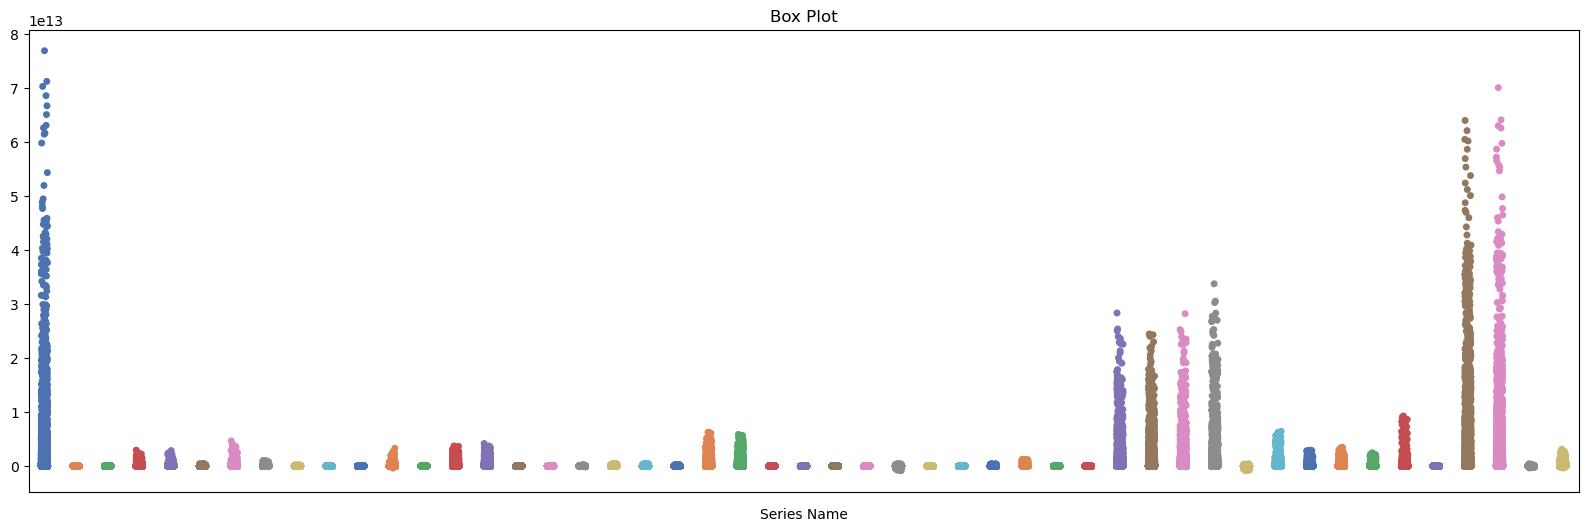

In [143]:
#Stripplot
plt.figure(figsize=(20, 6))
stripplot = sns.stripplot(data=df_filtered.iloc[:, 1:50], dodge=False, palette="deep")
plt.title('Box Plot')

# Rmove the names on x axis
stripplot.set_xticklabels([])
stripplot.tick_params(axis='x', bottom=False)
plt.show()

### Check outliers for variables expresed on escales of population

In [144]:
# Filter columns only for %
filtered_columns = [col for col in df.columns if 'per ' in col]
df_filtered = df[filtered_columns]

c:\Users\User\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\User\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


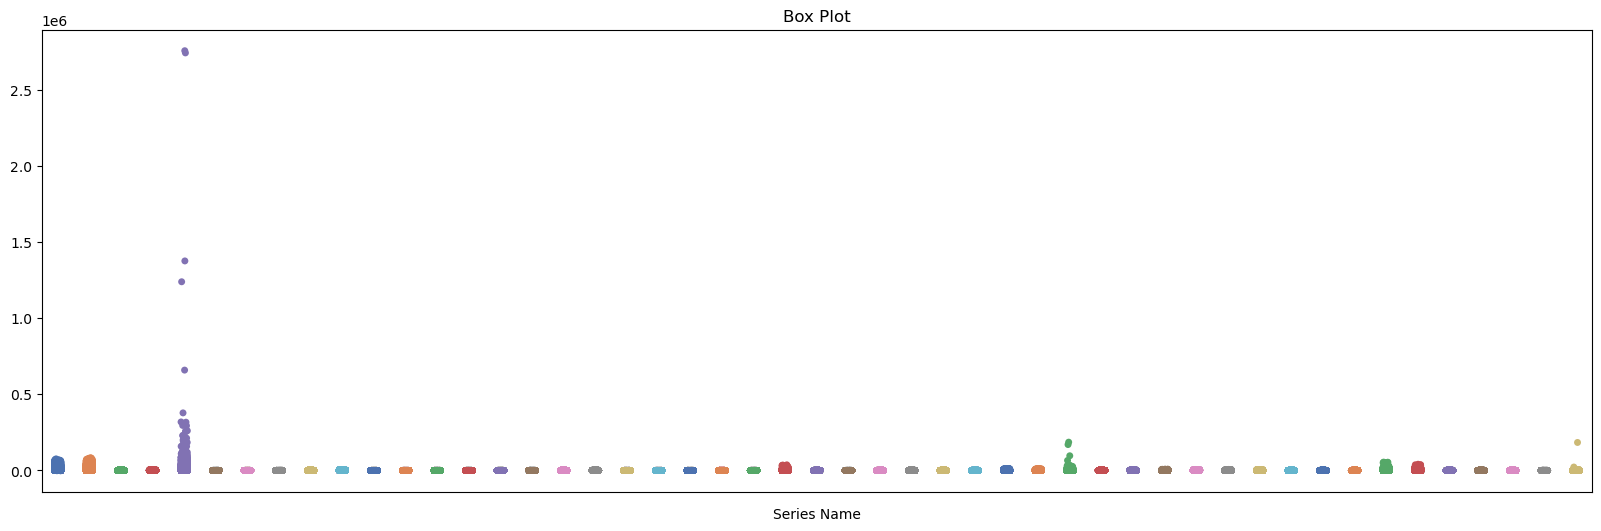

In [145]:
#Stripplot
plt.figure(figsize=(20, 6))
stripplot = sns.stripplot(data=df_filtered.iloc[:, 1:50], dodge=False, palette="deep")
plt.title('Box Plot')

# Rmove the names on x axis
stripplot.set_xticklabels([])
stripplot.tick_params(axis='x', bottom=False)
plt.show()

In [146]:
# Get the default variables
variables_default = [col for col in df.columns if col.startswith('Default')]

# Save the default variables on y
Y = df[variables_default]

In [147]:
# Calculate proportion of 1s over total for each variable
proportions = Y.mean()

print("Proportions of 1s over total for each variable:")
print(proportions)

Proportions of 1s over total for each variable:
Series Name
Default_China                         0.012411
Default_Domestic arrears              0.090483
Default_FC bank loans                 0.055536
Default_FC bonds                      0.021563
Default_IBRD                          0.009609
Default_IDA                           0.012011
Default_IMF                           0.019218
Default_LC debt                       0.010467
Default_Other official creditors      0.243937
Default_Other private creditors       0.168726
Default_Paris Club                    0.067605
Defaulted_Money                     790.867712
dtype: float64


This suggest the default variables on Y are unbalanced.

## Data Preparation

Following CRISP DM, the next step is Data Preparation. Performing the transformations required identified on the Data Understanding phase.

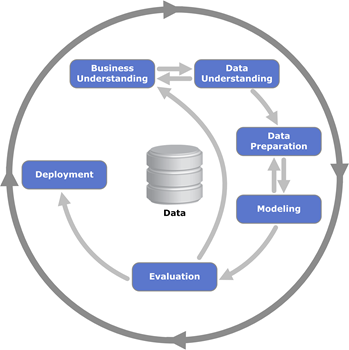


In [5]:
# Reset the dataset
df = df_2

In [6]:
#Scaler
scaler = StandardScaler()

In [7]:
# Imput missing values with the average of each country & variable
def fillna_with_row_mean(row):
    non_nan_values = row.iloc[2:]  # Ignore the first two columns (Country & Variables)
    row_mean = non_nan_values.mean()
    return row.fillna(row_mean)

df = df.apply(fillna_with_row_mean, axis=1)

In [8]:
# Unify names
df.loc[df['Country Name'] == 'Bahamas, The', 'Country Name'] = 'Bahamas'
df.loc[df['Country Name'] == 'Congo, Rep.', 'Country Name'] = 'Congo, Dem. Rep.'
df.loc[df['Country Name'] == 'Egypt, Arab Rep.', 'Country Name'] = 'Egypt'
df.loc[df['Country Name'] == 'Faeroe Islands', 'Country Name'] = 'Faroe Islands'

In [9]:
# Pivot and melt the table
df = df.melt(id_vars=['Country Name', 'Series Name'], var_name='Year', value_name='Value')
df = df.pivot_table(index=['Country Name', 'Year'], columns='Series Name', values='Value').reset_index()
df = df.rename(columns={'Country Name': 'C'})

In [10]:
#Exclude regions on the Country column
exclude = [
    'Africa Eastern and Southern',
    'Africa Western and Central',
    'Arab World',
    'Caribbean small states',
    'Central African Republic',
    'Central Europe and the Baltics',
    'Early-demographic dividend',
    'East Asia & Pacific',
    'East Asia & Pacific (IDA & IBRD countries)',
    'East Asia & Pacific (IDA & IBRD)',
    'East Asia & Pacific (excluding high income)',
    'Euro area',
    'Europe & Central Asia',
    'Europe & Central Asia (IDA & IBRD countries)',
    'Europe & Central Asia (IDA & IBRD)',
    'Europe & Central Asia (excluding high income)',
    'European Union',
    'Fragile and conflict affected situations',
    'Heavily indebted poor countries (HIPC)',
    'High income',
    'IBRD only',
    'IDA & IBRD total',
    'IDA blend',
    'IDA only',
    'IDA total',
    'Late-demographic dividend',
    'Latin America & Caribbean',
    'Latin America & Caribbean (IDA & IBRD)',
    'Latin America & Caribbean (excluding high income)',
    'Latin America & the Caribbean (IDA & IBRD countries)',
    'Least developed countries: UN classification',
    'Low & middle income',
    'Low income',
    'Lower middle income',
    'Middle East & North Africa',
    'Middle East & North Africa (IDA & IBRD countries)',
    'Middle East & North Africa (IDA & IBRD)',
    'Middle East & North Africa (excluding high income)',
    'Middle income',
    'North America',
    'OECD members',
    'Other small states',
    'Pacific island small states',
    'Post-demographic dividend',
    'Pre-demographic dividend',
    'Small states',
    'South Asia',
    'South Asia (IDA & IBRD)',
    'Sub-Saharan Africa',
    'Sub-Saharan Africa (IDA & IBRD countries)',
    'Sub-Saharan Africa (IDA & IBRD)',
    'Sub-Saharan Africa (excluding high income)',
    'Upper middle income',
    'West Bank and Gaza',
    'World'
]

df = df[~df['C'].isin(exclude)]

In [11]:
# Re-group the table
df = df.groupby(['C', 'Year']).sum().reset_index()

# Dummify
df=pd.get_dummies(df, columns= ['C'])
df=pd.get_dummies(df, columns= ['Year'])

In [12]:
# Drop specific columns by name
columns_to_drop = ['Net official flows from UN agencies, UNEP (current US$)', 'Net official flows from UN agencies, UNIDIR (current US$)', 'Defaulted_Money']
df = df.drop(columns=columns_to_drop)

In [13]:
df.describe()

,ARI treatment (% of children under 5 taken to a health provider),Access to clean fuels and technologies for cooking (% of population),"Access to clean fuels and technologies for cooking, rural (% of rural population)","Access to clean fuels and technologies for cooking, urban (% of urban population)",Access to electricity (% of population),"Access to electricity, rural (% of rural population)","Access to electricity, urban (% of urban population)",Account ownership at a financial institution or with a mobile-money-service provider (% of population ages 15+),"Account ownership at a financial institution or with a mobile-money-service provider, female (% of population ages 15+)","Account ownership at a financial institution or with a mobile-money-service provider, male (% of population ages 15+)",...,"Women participating in the three decisions (own health care, major household purchases, and visiting family) (% of women age 15-49)",Women who believe a husband is justified in beating his wife (any of five reasons) (%),Women who believe a husband is justified in beating his wife when she argues with him (%),Women who believe a husband is justified in beating his wife when she burns the food (%),Women who believe a husband is justified in beating his wife when she goes out without telling him (%),Women who believe a husband is justified in beating his wife when she neglects the children (%),Women who believe a husband is justified in beating his wife when she refuses sex with him (%),Women who were first married by age 18 (% of women ages 20-24),Women's share of population ages 15+ living with HIV (%),Young people (ages 15-24) newly infected with HIV
count,14198.000000,14198.000000,14198.000000,14198.000000,14198.000000,14198.000000,14198.000000,14198.000000,14198.000000,14198.000000,...,14198.000000,14198.000000,14198.000000,14198.000000,14198.000000,14198.000000,14198.000000,14198.000000,14198.000000,14198.000000
mean,31.988141,52.037783,45.284031,59.585535,74.463314,67.868233,82.985579,38.685529,36.547202,40.818981,...,15.437811,12.633855,7.484617,4.347251,8.354284,9.419551,5.830124,13.870713,27.922733,2551.374228
std,33.087644,42.760849,43.618820,42.576899,34.814201,39.228319,30.008788,35.188846,34.853610,35.748380,...,26.055242,22.263072,14.750102,9.100052,16.145460,16.972355,12.290268,16.886729,21.471328,11823.855096
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,2.300000,0.490909,6.077273,49.286415,25.897386,82.431677,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,31.300000,57.700000,31.715909,80.656818,96.645161,93.568210,99.384953,34.260000,29.013333,37.896667,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,27.721875,100.000000
75%,63.333333,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,69.740000,66.090000,73.347500,...,30.300000,19.500000,6.025000,3.500000,8.300000,13.800000,3.050000,25.800000,45.600000,609.375000
max,97.500000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,...,92.800000,92.100000,77.600000,64.500000,82.700000,81.000000,73.500000,83.500000,89.700000,230000.000000


Now, the distance between the average and the median is shorter than before.

In [14]:
df.shape

(14198, 1776)

In [15]:
#Check the statistics for random columns
random_columns = df.sample(10, axis=1)
random_columns.describe()

,Coverage of unemployment benefits and ALMP in poorest quintile (% of population),"Secondary education, teachers (% female)","Mortality rate attributed to household and ambient air pollution, age-standardized, female (per 100,000 female population)","Net official flows from UN agencies, UNFPA (current US$)","Government expenditure per student, primary (% of GDP per capita)",Lending interest rate (%),Capture fisheries production (metric tons),"Number of surgical procedures (per 100,000 population)"
count,14198.000000,14198.000000,14198.000000,1.419800e+04,14198.000000,14198.000000,1.419800e+04,14198.000000
mean,1.576612,42.357844,67.253275,7.970438e+05,10.891024,23.538148,3.176231e+05,2610.612082
std,4.257292,23.347549,69.723045,1.425455e+06,8.833776,848.372523,1.137417e+06,4993.931242
min,0.000000,0.000000,0.000000,-7.397439e+05,0.000000,0.000000,0.000000e+00,0.000000
25%,0.000000,24.477729,8.000000,0.000000e+00,0.000000,0.000000,5.100000e+02,0.000000
50%,0.000000,47.649101,37.200000,1.712500e+05,10.602087,7.360836,1.100000e+04,0.000000
75%,0.763133,60.334213,117.300000,9.600000e+05,16.957945,14.538767,1.251907e+05,3005.000000
max,47.564955,95.066330,265.000000,2.312000e+07,65.101020,99764.532950,1.664793e+07,28907.000000


In [16]:
# Get the default variables
variables_default = [col for col in df.columns if col.startswith('Default')]

# save on Y the default variables
Y = df[variables_default]

# The last variables are located on X
X = df.drop(variables_default, axis=1)

In [17]:
# Calculate the proportions on the new data set
proportions = Y.mean()

print("Proportions of 1s over total for each variable:")
print(proportions)

Proportions of 1s over total for each variable:
Default_China                       0.015002
Default_Domestic arrears            0.108677
Default_FC bank loans               0.068319
Default_FC bonds                    0.026553
Default_IBRD                        0.011833
Default_IDA                         0.014368
Default_IMF                         0.023031
Default_LC debt                     0.012889
Default_Other official creditors    0.296732
Default_Other private creditors     0.204113
Default_Paris Club                  0.081843
dtype: float64


### Data Balance

In order to balance the dataset, the ensemble method is applied to balance the dataframe.

In [18]:
# Define a base classifier
clf = RandomForestClassifier(n_estimators=100, max_depth=15, random_state=69)

# Define oversampling methods
ros = RandomOverSampler(random_state=42)
smote = SMOTE(random_state=42)
adasyn = ADASYN(random_state=42)

# Create pipelines for each oversampling method
pipelines = {
    'Random Oversampling': make_pipeline(ros, clf),
    'SMOTE': make_pipeline(smote, clf),
    'ADASYN': make_pipeline(adasyn, clf),
    'No Oversampling': clf}  # No oversampling

In [177]:
# Iterate over each column in Y
for col in Y.columns:
    # Create the DataFrame for X with the variables that do not include the current column
    X_resampled = X

    # Select the current column from Y for cross-validation
    y_resampled = Y[col]

    # Perform cross-validation and compare performance
    print(f"\nVariable: {col}")
    for name, pipeline in pipelines.items():
        scores = cross_val_score(pipeline, X_resampled, y_resampled, scoring='f1', cv=5)
        print(f'{name}: Mean F1-Score {np.mean(scores):.3f}, Standard Deviation {np.std(scores):.3f}')


Variable: Default_China
Random Oversampling: Mean F1-Score 0.099, Standard Deviation 0.056
SMOTE: Mean F1-Score 0.147, Standard Deviation 0.089
ADASYN: Mean F1-Score 0.141, Standard Deviation 0.058
No Oversampling: Mean F1-Score 0.026, Standard Deviation 0.051

Variable: Default_Domestic arrears
Random Oversampling: Mean F1-Score 0.426, Standard Deviation 0.118
SMOTE: Mean F1-Score 0.469, Standard Deviation 0.091
ADASYN: Mean F1-Score 0.459, Standard Deviation 0.078
No Oversampling: Mean F1-Score 0.403, Standard Deviation 0.127

Variable: Default_FC bank loans
Random Oversampling: Mean F1-Score 0.255, Standard Deviation 0.071
SMOTE: Mean F1-Score 0.300, Standard Deviation 0.064
ADASYN: Mean F1-Score 0.281, Standard Deviation 0.048
No Oversampling: Mean F1-Score 0.067, Standard Deviation 0.035

Variable: Default_FC bonds
Random Oversampling: Mean F1-Score 0.117, Standard Deviation 0.096
SMOTE: Mean F1-Score 0.115, Standard Deviation 0.097
ADASYN: Mean F1-Score 0.121, Standard Deviation

In [19]:
#adasyn, smote y ros
ros = RandomOverSampler(random_state=42)
smote = SMOTE(random_state=42)
adasyn = ADASYN(random_state=42)

#Define X & Y
X_resampled = X
y_resampled = Y['Default_China']

#China
X_resampled_China, y_resampled_China = adasyn.fit_resample(X_resampled, y_resampled)
df_resampled_China = pd.concat([X_resampled_China, y_resampled_China], axis=1)

#Define X & Y
X_resampled = X
y_resampled = Y['Default_Domestic arrears']

#Domestic Arrears
X_resampled_Domestic_Arrears, y_resampled_Domestic_Arrears = smote.fit_resample(X_resampled, y_resampled)
df_resampled_Domestic_Arrears = pd.concat([X_resampled_Domestic_Arrears, y_resampled_Domestic_Arrears], axis=1)

#Define X & Y
X_resampled = X
y_resampled = Y['Default_FC bank loans']

#FC Bank Loans
X_resampled_FC_Bank_Loans, y_resampled_FC_Bank_Loans = adasyn.fit_resample(X_resampled, y_resampled)
df_resampled_FC_Bank_Loans = pd.concat([X_resampled_FC_Bank_Loans, y_resampled_FC_Bank_Loans], axis=1)

#Define X & Y
X_resampled = X
y_resampled = Y['Default_FC bonds']

#FC Bonds
X_resampled_Default_FC_bonds, y_resampled_Default_FC_bonds = adasyn.fit_resample(X_resampled, y_resampled)
df_resampled_Default_FC_bonds = pd.concat([X_resampled_Default_FC_bonds, y_resampled_Default_FC_bonds], axis=1)

#Define X & Y
X_resampled = X
y_resampled = Y['Default_IBRD']

#IBRD
X_resampled_Default_IBRD, y_resampled_Default_IBRD = ros.fit_resample(X_resampled, y_resampled)
df_resampled_Default_IBRD = pd.concat([X_resampled_Default_IBRD, y_resampled_Default_IBRD], axis=1)

#Define X & Y
X_resampled = X
y_resampled = Y['Default_IDA']

#IDA
X_resampled_Default_IDA, y_resampled_Default_IDA = ros.fit_resample(X_resampled, y_resampled)
df_resampled_Default_IDA = pd.concat([X_resampled_Default_IDA, y_resampled_Default_IDA], axis=1)

#Define X & Y
X_resampled = X
y_resampled = Y['Default_IMF']

#IMF
X_resampled_Default_IMF, y_resampled_Default_IMF = adasyn.fit_resample(X_resampled, y_resampled)
df_resampled_Default_IMF = pd.concat([X_resampled_Default_IMF, y_resampled_Default_IMF], axis=1)

#Define X & Y
X_resampled = X
y_resampled = Y['Default_LC debt']

#LC Debt
X_resampled_Default_LC_debt, y_resampled_Default_LC_debt = adasyn.fit_resample(X_resampled, y_resampled)
df_resampled_Default_LC_debt = pd.concat([X_resampled_Default_LC_debt, y_resampled_Default_LC_debt], axis=1)

#Define X & Y
X_resampled = X
y_resampled = Y['Default_Other official creditors']

#Other official creditors
X_resampled_Default_Other_official_creditors, y_resampled_Default_Other_official_creditors = adasyn.fit_resample(X_resampled, y_resampled)
df_resampled_Default_Other_official_creditors = pd.concat([X_resampled_Default_Other_official_creditors, y_resampled_Default_Other_official_creditors], axis=1)

#Define X & Y
X_resampled = X
y_resampled = Y['Default_Other private creditors']

#Other private creditors
X_resampled_Default_Other_private_creditors, y_resampled_Default_Other_private_creditors = adasyn.fit_resample(X_resampled, y_resampled)
df_resampled_Default_Other_private_creditors = pd.concat([X_resampled_Default_Other_private_creditors, y_resampled_Default_Other_private_creditors], axis=1)

#Define X & Y
X_resampled = X
y_resampled = Y['Default_Paris Club']

#Paris Club
X_resampled_Default_Paris_Club, y_resampled_Default_Paris_Club = adasyn.fit_resample(X_resampled, y_resampled)
df_resampled_Default_Paris_Club = pd.concat([X_resampled_Default_Paris_Club, y_resampled_Default_Paris_Club], axis=1)

### Train - Test Split

In [20]:
# Train-test split for China
X_train_China, X_test_China, y_train_China, y_test_China = train_test_split(X_resampled_China, y_resampled_China, test_size=0.2, random_state=42)

# Train-test split for Domestic Arrears
X_train_Domestic_Arrears, X_test_Domestic_Arrears, y_train_Domestic_Arrears, y_test_Domestic_Arrears = train_test_split(X_resampled_Domestic_Arrears, y_resampled_Domestic_Arrears, test_size=0.2, random_state=42)

# Train-test split for FC Bank Loans
X_train_FC_Bank_Loans, X_test_FC_Bank_Loans, y_train_FC_Bank_Loans, y_test_FC_Bank_Loans = train_test_split(X_resampled_FC_Bank_Loans, y_resampled_FC_Bank_Loans, test_size=0.2, random_state=42)

# Train-test split for FC Bonds
X_train_Default_FC_bonds, X_test_Default_FC_bonds, y_train_Default_FC_bonds, y_test_Default_FC_bonds = train_test_split(X_resampled_Default_FC_bonds, y_resampled_Default_FC_bonds, test_size=0.2, random_state=42)

# Train-test split for IBRD
X_train_Default_IBRD, X_test_Default_IBRD, y_train_Default_IBRD, y_test_Default_IBRD = train_test_split(X_resampled_Default_IBRD, y_resampled_Default_IBRD, test_size=0.2, random_state=42)

# Train-test split for IDA
X_train_Default_IDA, X_test_Default_IDA, y_train_Default_IDA, y_test_Default_IDA = train_test_split(X_resampled_Default_IDA, y_resampled_Default_IDA, test_size=0.2, random_state=42)

# Train-test split for IMF
X_train_Default_IMF, X_test_Default_IMF, y_train_Default_IMF, y_test_Default_IMF = train_test_split(X_resampled_Default_IMF, y_resampled_Default_IMF, test_size=0.2, random_state=42)

# Train-test split for LC Debt
X_train_Default_LC_debt, X_test_Default_LC_debt, y_train_Default_LC_debt, y_test_Default_LC_debt = train_test_split(X_resampled_Default_LC_debt, y_resampled_Default_LC_debt, test_size=0.2, random_state=42)

# Train-test split for Other official creditors
X_train_Default_Other_official_creditors, X_test_Default_Other_official_creditors, y_train_Default_Other_official_creditors, y_test_Default_Other_official_creditors = train_test_split(X_resampled_Default_Other_official_creditors, y_resampled_Default_Other_official_creditors, test_size=0.2, random_state=42)

# Train-test split for Other private creditors
X_train_Default_Other_private_creditors, X_test_Default_Other_private_creditors, y_train_Default_Other_private_creditors, y_test_Default_Other_private_creditors = train_test_split(X_resampled_Default_Other_private_creditors, y_resampled_Default_Other_private_creditors, test_size=0.2, random_state=42)

# Train-test split for Paris Club
X_train_Default_Paris_Club, X_test_Default_Paris_Club, y_train_Default_Paris_Club, y_test_Default_Paris_Club = train_test_split(X_resampled_Default_Paris_Club, y_resampled_Default_Paris_Club, test_size=0.2, random_state=42)

## Modeling

Models to apply:
- Fuzzy Decision Trees
- AdaBoost
- XGBoost
- Deep Learning Neural Decision Trees (Error - Not deployed)
- Support Vector Machines (Error - Not deployed)
- Artificial Neuronal Networks

### Fuzzy Decision Tree

In [180]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc
import matplotlib.pyplot as plt

def run_fuzzy_decision_tree(X_train, X_test, y_train, y_test):
    # Crear y entrenar el modelo
    model = DecisionTreeClassifier(criterion='entropy')
    model.fit(X_train, y_train)

    y_proba = model.predict_proba(X_test)[:, 1]  # Probabilities of positive class
    
    y_pred = model.predict(X_test)

    # Performance Metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    # COR
    fpr, tpr, thresholds = roc_curve(y_test, y_proba)
    roc_auc = auc(fpr, tpr)

    return accuracy, precision, recall, f1, fpr, tpr, roc_auc

In [181]:
results = {}

# Iterate over train & test for all the default categories
for name, X_train, X_test, y_train, y_test in [
    ('China', X_train_China, X_test_China, y_train_China, y_test_China),
    ('Domestic Arrears', X_train_Domestic_Arrears, X_test_Domestic_Arrears, y_train_Domestic_Arrears, y_test_Domestic_Arrears),
    ('FC Bank Loans', X_train_FC_Bank_Loans, X_test_FC_Bank_Loans, y_train_FC_Bank_Loans, y_test_FC_Bank_Loans),
    ('FC Bonds', X_train_Default_FC_bonds, X_test_Default_FC_bonds, y_train_Default_FC_bonds, y_test_Default_FC_bonds),
    ('IBRD', X_train_Default_IBRD, X_test_Default_IBRD, y_train_Default_IBRD, y_test_Default_IBRD),
    ('IDA', X_train_Default_IDA, X_test_Default_IDA, y_train_Default_IDA, y_test_Default_IDA),
    ('IMF', X_train_Default_IMF, X_test_Default_IMF, y_train_Default_IMF, y_test_Default_IMF),
    ('LC Debt', X_train_Default_LC_debt, X_test_Default_LC_debt, y_train_Default_LC_debt, y_test_Default_LC_debt),
    ('Other official creditors', X_train_Default_Other_official_creditors, X_test_Default_Other_official_creditors, y_train_Default_Other_official_creditors, y_test_Default_Other_official_creditors),
    ('Other private creditors', X_train_Default_Other_private_creditors, X_test_Default_Other_private_creditors, y_train_Default_Other_private_creditors, y_test_Default_Other_private_creditors),
    ('Paris Club', X_train_Default_Paris_Club, X_test_Default_Paris_Club, y_train_Default_Paris_Club, y_test_Default_Paris_Club)
]:
    accuracy, precision, recall, f1, fpr, tpr, roc_auc = run_fuzzy_decision_tree(X_train, X_test, y_train, y_test)
    results[name] = {
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1,
        'FPR': fpr,
        'TPR': tpr,
        'ROC AUC': roc_auc
    }

In [182]:
# Table with the results
import pandas as pd
results_df = pd.DataFrame(results).T
print(results_df)

                          Accuracy Precision    Recall  F1 Score  \
China                     0.987661  0.984995  0.990302  0.987641   
Domestic Arrears          0.982418  0.980861  0.983607  0.982232   
FC Bank Loans             0.979867  0.970917  0.989362  0.980053   
FC Bonds                  0.992949  0.989661  0.996411  0.993025   
IBRD                      0.997684  0.995408       1.0  0.997699   
IDA                        0.99875  0.997465       1.0  0.998731   
IMF                       0.990256  0.986086  0.994602  0.990326   
LC Debt                   0.992147  0.990644  0.993504  0.992072   
Other official creditors  0.946112  0.938681  0.959472  0.948963   
Other private creditors   0.962059  0.961795  0.962222  0.962008   
Paris Club                0.968142  0.960689  0.976408  0.968485   

                                                        FPR  \
China                      [0.0, 0.014957264957264958, 1.0]   
Domestic Arrears           [0.0, 0.018742678641155797, 1.

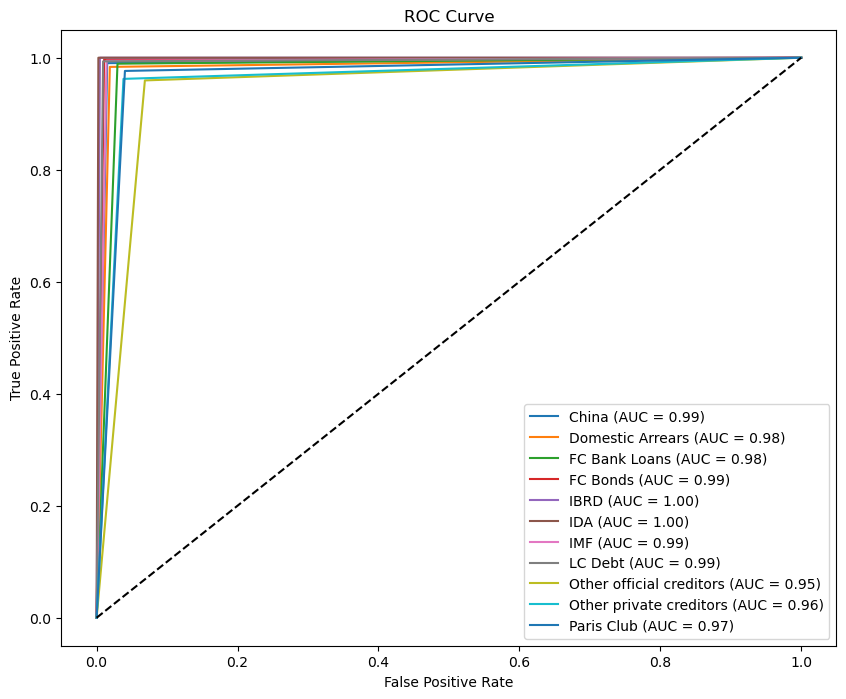

In [183]:
# ROC curve
plt.figure(figsize=(10, 8))
for name, result in results.items():
    plt.plot(result['FPR'], result['TPR'], label=f'{name} (AUC = {result["ROC AUC"]:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

### AdaBoost

In [21]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc
import matplotlib.pyplot as plt

def run_adaboost(X_train, X_test, y_train, y_test):
    # Create and train the AdaBoost model
    base_estimator = DecisionTreeClassifier(criterion='entropy', max_depth=5)  # Decision tree with max_depth=1
    model = AdaBoostClassifier(base_estimator=base_estimator, n_estimators=1)  # 50 weak learners
    model.fit(X_train, y_train)

    # Predict probabilities on the test set
    y_proba = model.predict_proba(X_test)[:, 1]  # Probabilities of positive class

    # Predict labels on the test set
    y_pred = model.predict(X_test)

    # Calculate performance metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    # Calculate ROC curve
    fpr, tpr, thresholds = roc_curve(y_test, y_proba)  # Using probabilities instead of labels
    roc_auc = auc(fpr, tpr)

    return accuracy, precision, recall, f1, fpr, tpr, roc_auc

In [22]:
results = {}

# Iterate
for name, X_train, X_test, y_train, y_test in [
    ('China', X_train_China, X_test_China, y_train_China, y_test_China),
    ('Domestic Arrears', X_train_Domestic_Arrears, X_test_Domestic_Arrears, y_train_Domestic_Arrears, y_test_Domestic_Arrears),
    ('FC Bank Loans', X_train_FC_Bank_Loans, X_test_FC_Bank_Loans, y_train_FC_Bank_Loans, y_test_FC_Bank_Loans),
    ('FC Bonds', X_train_Default_FC_bonds, X_test_Default_FC_bonds, y_train_Default_FC_bonds, y_test_Default_FC_bonds),
    ('IBRD', X_train_Default_IBRD, X_test_Default_IBRD, y_train_Default_IBRD, y_test_Default_IBRD),
    ('IDA', X_train_Default_IDA, X_test_Default_IDA, y_train_Default_IDA, y_test_Default_IDA),
    ('IMF', X_train_Default_IMF, X_test_Default_IMF, y_train_Default_IMF, y_test_Default_IMF),
    ('LC Debt', X_train_Default_LC_debt, X_test_Default_LC_debt, y_train_Default_LC_debt, y_test_Default_LC_debt),
    ('Other official creditors', X_train_Default_Other_official_creditors, X_test_Default_Other_official_creditors, y_train_Default_Other_official_creditors, y_test_Default_Other_official_creditors),
    ('Other private creditors', X_train_Default_Other_private_creditors, X_test_Default_Other_private_creditors, y_train_Default_Other_private_creditors, y_test_Default_Other_private_creditors),
    ('Paris Club', X_train_Default_Paris_Club, X_test_Default_Paris_Club, y_train_Default_Paris_Club, y_test_Default_Paris_Club)
]:
    accuracy, precision, recall, f1, fpr, tpr, roc_auc = run_adaboost(X_train, X_test, y_train, y_test)
    results[name] = {
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1,
        'FPR': fpr,
        'TPR': tpr,
        'ROC AUC': roc_auc
    }

c:\Users\User\anaconda3\Lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
c:\Users\User\anaconda3\Lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
c:\Users\User\anaconda3\Lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
c:\Users\User\anaconda3\Lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
c:\Users\User\anaconda3\Lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
c:\Users\User\anaconda3\Lib\site-package

In [23]:
# Table with results
import pandas as pd
results_df = pd.DataFrame(results).T
print(results_df)

                          Accuracy Precision    Recall  F1 Score  \
China                     0.927396  0.891892  0.971983  0.930217   
Domestic Arrears          0.871395  0.851177  0.896441  0.873223   
FC Bank Loans             0.862298  0.815624   0.93617   0.87175   
FC Bonds                  0.780329  0.696326       1.0  0.820981   
IBRD                      0.956522  0.930723   0.98687  0.957975   
IDA                       0.984816   0.97006       1.0  0.984802   
IMF                       0.840491  0.765183  0.983807  0.860831   
LC Debt                   0.915046  0.924528   0.90184  0.913043   
Other official creditors  0.818159  0.820287   0.83459  0.827377   
Other private creditors   0.802751  0.754013  0.897778  0.819639   
Paris Club                0.821633  0.761831  0.937215  0.840471   

                                                                        FPR  \
China                     [0.0, 0.00035612535612535614, 0.00213675213675...   
Domestic Arrears         

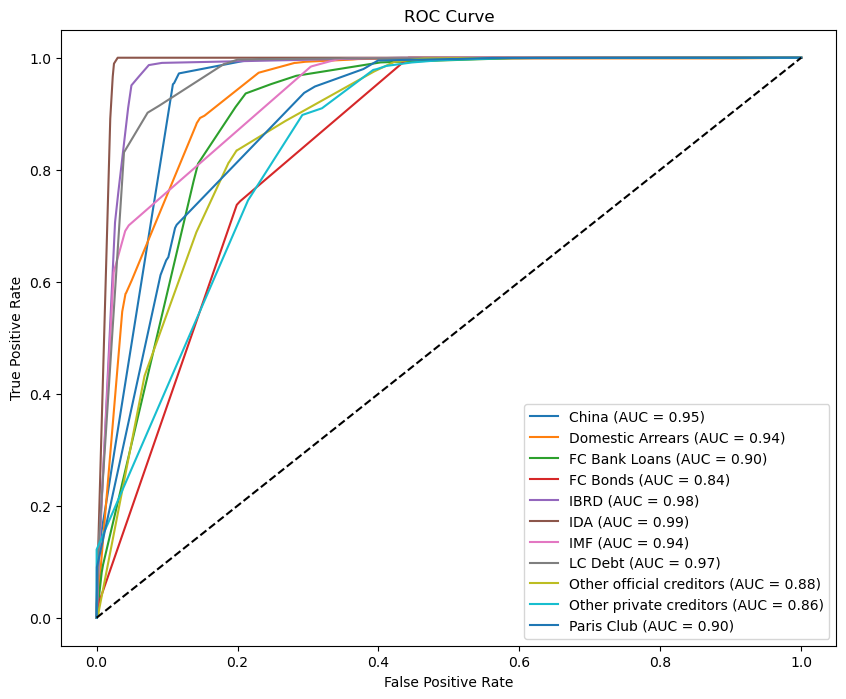

In [187]:
# ROC curve
plt.figure(figsize=(10, 8))
for name, result in results.items():
    plt.plot(result['FPR'], result['TPR'], label=f'{name} (AUC = {result["ROC AUC"]:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

### XGBoost

In [188]:
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc
import matplotlib.pyplot as plt

def run_xgboost(X_train, X_test, y_train, y_test):
    # Create and train the XGBoost model
    model = XGBClassifier(objective='binary:logistic', max_depth=15, n_estimators=200, eval_metric='error')
    model.fit(X_train, y_train)

    # Predict probabilities on the test set
    y_proba = model.predict_proba(X_test)[:, 1]  # Probabilities of positive class

    # Predict labels on the test set
    y_pred = model.predict(X_test)

    # Calculate performance metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    # Calculate ROC curve
    fpr, tpr, thresholds = roc_curve(y_test, y_proba)  # Using probabilities instead of labels
    roc_auc = auc(fpr, tpr)

    return accuracy, precision, recall, f1, fpr, tpr, roc_auc

In [189]:
results = {}

# Iterate
for name, X_train, X_test, y_train, y_test in [
    ('China', X_train_China, X_test_China, y_train_China, y_test_China),
    ('Domestic Arrears', X_train_Domestic_Arrears, X_test_Domestic_Arrears, y_train_Domestic_Arrears, y_test_Domestic_Arrears),
    ('FC Bank Loans', X_train_FC_Bank_Loans, X_test_FC_Bank_Loans, y_train_FC_Bank_Loans, y_test_FC_Bank_Loans),
    ('FC Bonds', X_train_Default_FC_bonds, X_test_Default_FC_bonds, y_train_Default_FC_bonds, y_test_Default_FC_bonds),
    ('IBRD', X_train_Default_IBRD, X_test_Default_IBRD, y_train_Default_IBRD, y_test_Default_IBRD),
    ('IDA', X_train_Default_IDA, X_test_Default_IDA, y_train_Default_IDA, y_test_Default_IDA),
    ('IMF', X_train_Default_IMF, X_test_Default_IMF, y_train_Default_IMF, y_test_Default_IMF),
    ('LC Debt', X_train_Default_LC_debt, X_test_Default_LC_debt, y_train_Default_LC_debt, y_test_Default_LC_debt),
    ('Other official creditors', X_train_Default_Other_official_creditors, X_test_Default_Other_official_creditors, y_train_Default_Other_official_creditors, y_test_Default_Other_official_creditors),
    ('Other private creditors', X_train_Default_Other_private_creditors, X_test_Default_Other_private_creditors, y_train_Default_Other_private_creditors, y_test_Default_Other_private_creditors),
    ('Paris Club', X_train_Default_Paris_Club, X_test_Default_Paris_Club, y_train_Default_Paris_Club, y_test_Default_Paris_Club)
]:
    accuracy, precision, recall, f1, fpr, tpr, roc_auc = run_xgboost(X_train, X_test, y_train, y_test)
    results[name] = {
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1,
        'FPR': fpr,
        'TPR': tpr,
        'ROC AUC': roc_auc
    }

In [190]:
# Results
import pandas as pd
results_df = pd.DataFrame(results).T
print(results_df)

                          Accuracy Precision    Recall  F1 Score  \
China                     0.996781  0.995344  0.998204  0.996772   
Domestic Arrears          0.993876  0.989691  0.998001  0.993828   
FC Bank Loans             0.990503  0.987538  0.993541   0.99053   
FC Bonds                  0.996565  0.994637  0.998564  0.996597   
IBRD                      0.998931  0.997875       1.0  0.998937   
IDA                       0.999285   0.99855       1.0  0.999274   
IMF                       0.996391  0.995332  0.997481  0.996405   
LC Debt                   0.996609  0.995677  0.997474  0.996575   
Other official creditors  0.972441  0.961009  0.987276  0.973966   
Other private creditors   0.981362  0.972101  0.991111  0.981514   
Paris Club                0.985502  0.975764  0.995814  0.985687   

                                                                        FPR  \
China                     [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
Domestic Arrears         

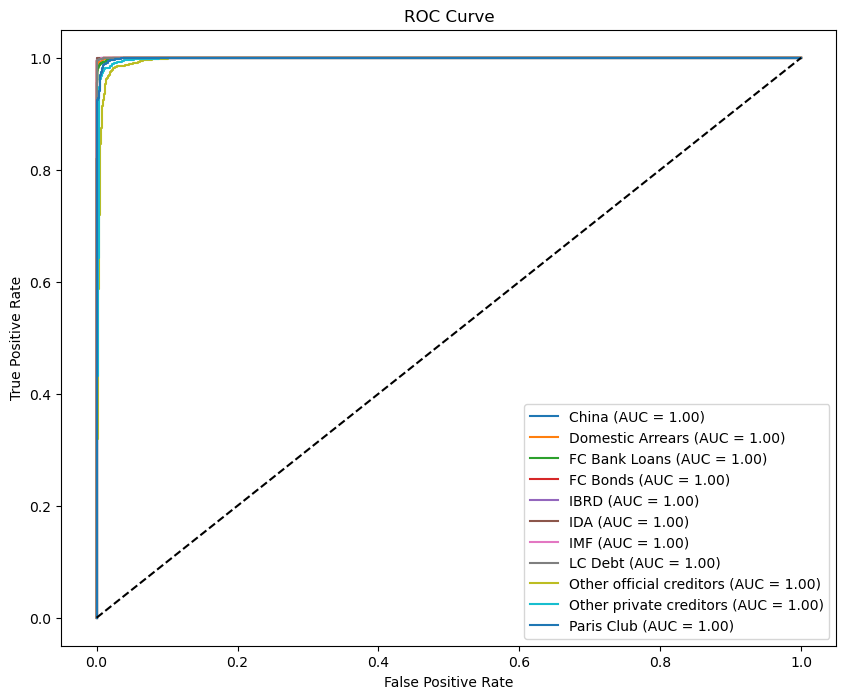

In [191]:
# Plot ROC curve
plt.figure(figsize=(10, 8))
for name, result in results.items():
    plt.plot(result['FPR'], result['TPR'], label=f'{name} (AUC = {result["ROC AUC"]:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

### ANN

In [192]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc
import matplotlib.pyplot as plt

def run_neural_decision_tree(X_train, X_test, y_train, y_test):
    # Create and train the Neural Decision Tree model
    model = MLPClassifier(hidden_layer_sizes=(100,), activation='relu', solver='adam', max_iter=1000)
    model.fit(X_train, y_train)

    # Predict probabilities on the test set
    y_proba = model.predict_proba(X_test)[:, 1]  # Probabilities of positive class

    # Predict labels on the test set
    y_pred = model.predict(X_test)

    # Calculate performance metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    # Calculate ROC curve
    fpr, tpr, thresholds = roc_curve(y_test, y_proba)  # Using probabilities instead of labels
    roc_auc = auc(fpr, tpr)

    return accuracy, precision, recall, f1, fpr, tpr, roc_auc

In [193]:
results = {}

# Iterate
for name, X_train, X_test, y_train, y_test in [
    ('China', X_train_China, X_test_China, y_train_China, y_test_China),
    ('Domestic Arrears', X_train_Domestic_Arrears, X_test_Domestic_Arrears, y_train_Domestic_Arrears, y_test_Domestic_Arrears),
    ('FC Bank Loans', X_train_FC_Bank_Loans, X_test_FC_Bank_Loans, y_train_FC_Bank_Loans, y_test_FC_Bank_Loans),
    ('FC Bonds', X_train_Default_FC_bonds, X_test_Default_FC_bonds, y_train_Default_FC_bonds, y_test_Default_FC_bonds),
    ('IBRD', X_train_Default_IBRD, X_test_Default_IBRD, y_train_Default_IBRD, y_test_Default_IBRD),
    ('IDA', X_train_Default_IDA, X_test_Default_IDA, y_train_Default_IDA, y_test_Default_IDA),
    ('IMF', X_train_Default_IMF, X_test_Default_IMF, y_train_Default_IMF, y_test_Default_IMF),
    ('LC Debt', X_train_Default_LC_debt, X_test_Default_LC_debt, y_train_Default_LC_debt, y_test_Default_LC_debt),
    ('Other official creditors', X_train_Default_Other_official_creditors, X_test_Default_Other_official_creditors, y_train_Default_Other_official_creditors, y_test_Default_Other_official_creditors),
    ('Other private creditors', X_train_Default_Other_private_creditors, X_test_Default_Other_private_creditors, y_train_Default_Other_private_creditors, y_test_Default_Other_private_creditors),
    ('Paris Club', X_train_Default_Paris_Club, X_test_Default_Paris_Club, y_train_Default_Paris_Club, y_test_Default_Paris_Club)
]:
    accuracy, precision, recall, f1, fpr, tpr, roc_auc = run_xgboost(X_train, X_test, y_train, y_test)
    results[name] = {
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1,
        'FPR': fpr,
        'TPR': tpr,
        'ROC AUC': roc_auc
    }

In [194]:
# Results
import pandas as pd
results_df = pd.DataFrame(results).T
print(results_df)

                          Accuracy Precision    Recall  F1 Score  \
China                     0.996781  0.995344  0.998204  0.996772   
Domestic Arrears          0.993876  0.989691  0.998001  0.993828   
FC Bank Loans             0.990503  0.987538  0.993541   0.99053   
FC Bonds                  0.996565  0.994637  0.998564  0.996597   
IBRD                      0.998931  0.997875       1.0  0.998937   
IDA                       0.999285   0.99855       1.0  0.999274   
IMF                       0.996391  0.995332  0.997481  0.996405   
LC Debt                   0.996609  0.995677  0.997474  0.996575   
Other official creditors  0.972441  0.961009  0.987276  0.973966   
Other private creditors   0.981362  0.972101  0.991111  0.981514   
Paris Club                0.985502  0.975764  0.995814  0.985687   

                                                                        FPR  \
China                     [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
Domestic Arrears         

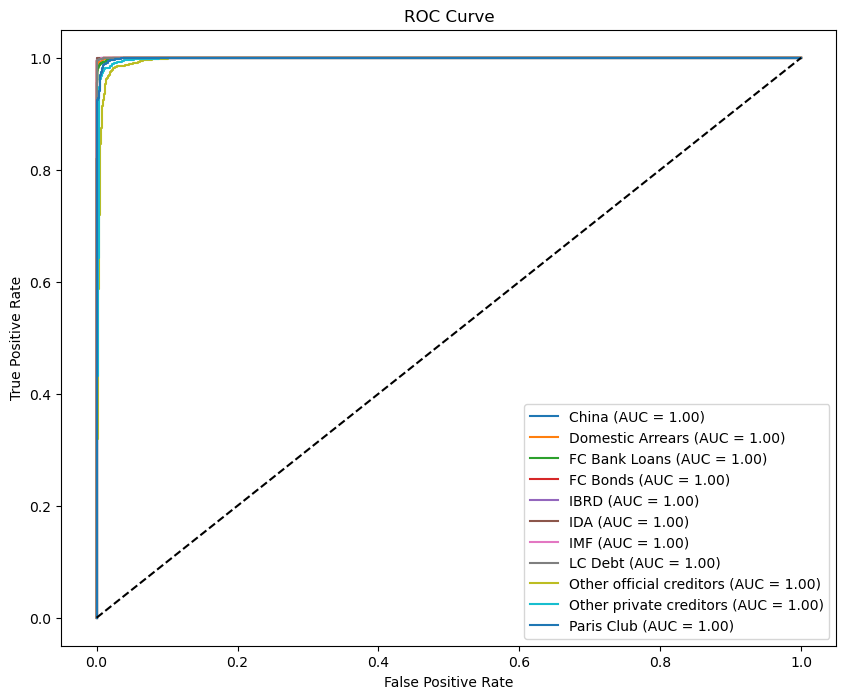

In [195]:
# Plot ROC curve
plt.figure(figsize=(10, 8))
for name, result in results.items():
    plt.plot(result['FPR'], result['TPR'], label=f'{name} (AUC = {result["ROC AUC"]:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

## Explainable ML

In [196]:
import numpy as np
import pandas as pd
import xgboost as xgb
import shap

# Crear un conjunto de datos de ejemplo
np.random.seed(199)

# Entrenar el modelo XGBoost
model = xgb.XGBClassifier(objective='binary:logistic', max_depth=15, n_estimators=200, eval_metric='error')

In [197]:
model.fit(X_train_China, y_train_China)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='error', feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=15, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=200, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [198]:
# Implement SHAP to explain the model predictions
explainer = shap.explainers.Tree(model, data=None, model_output='raw', feature_perturbation='interventional', feature_names=X_test_China.columns, approximate=False)
shap_values = explainer(X_train_China)

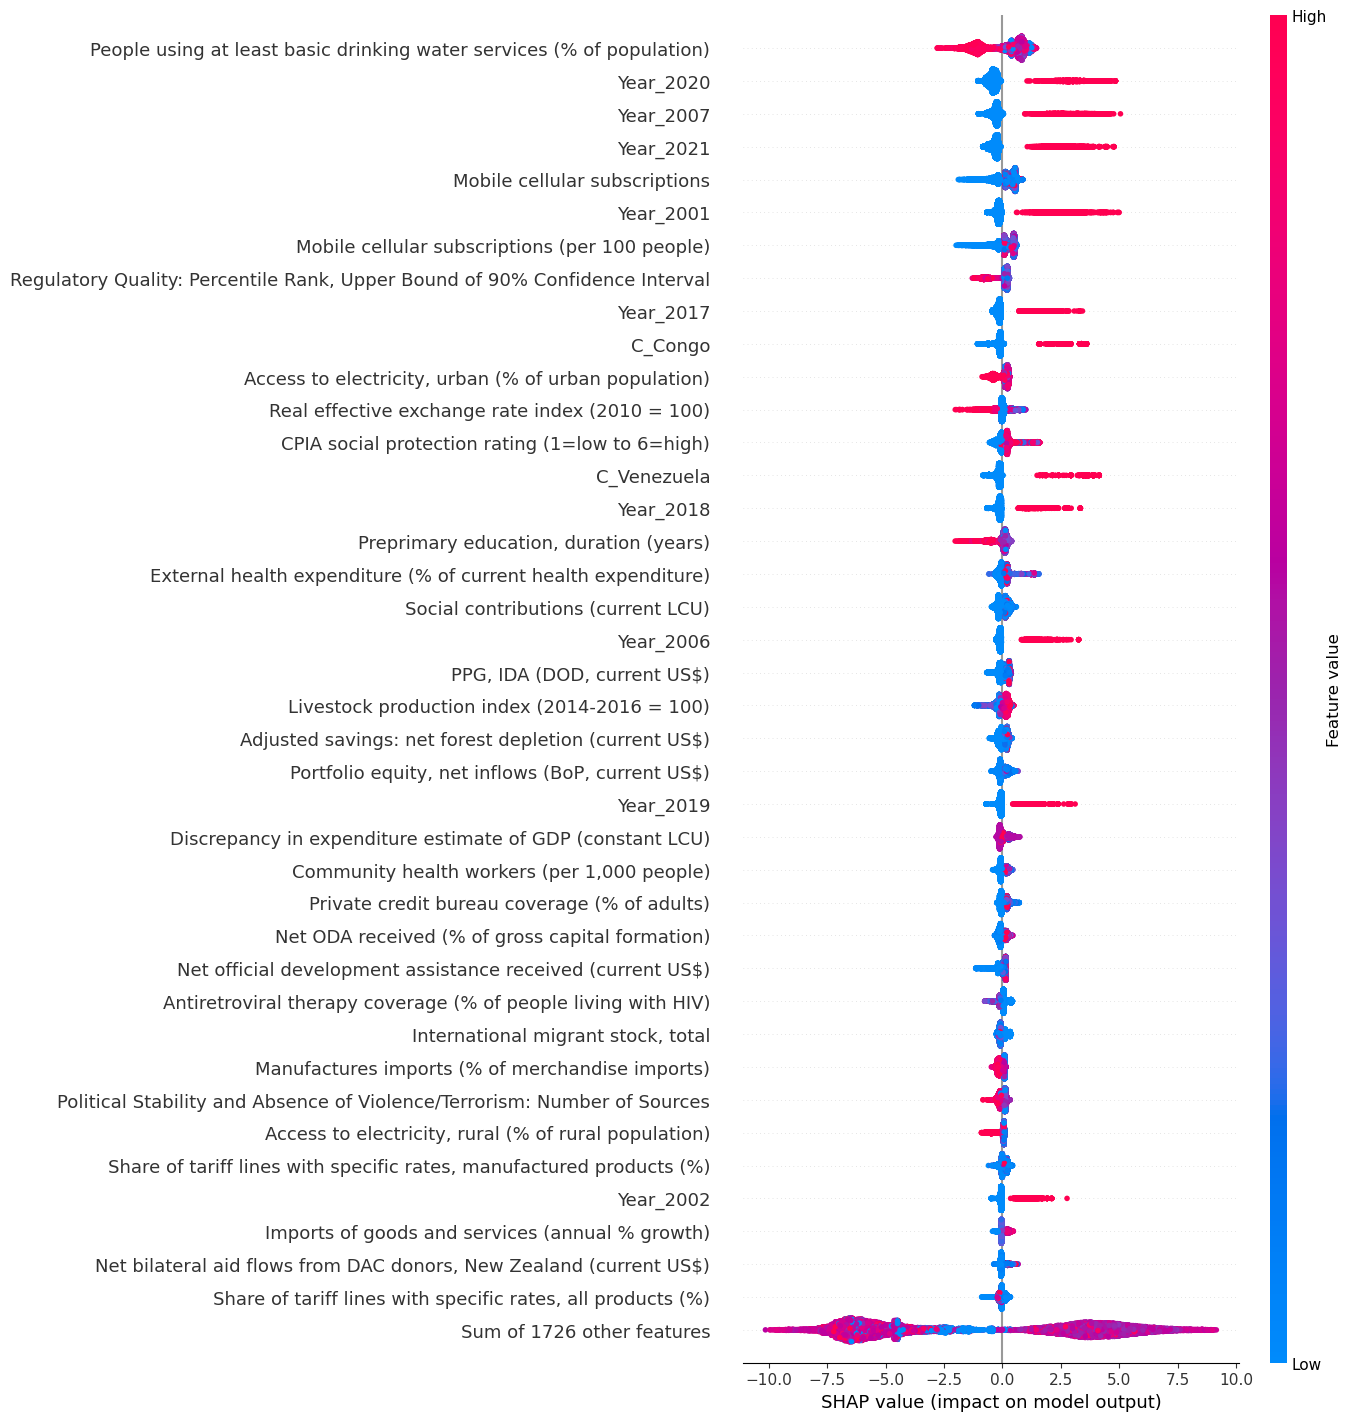

In [199]:
shap.plots.beeswarm(shap_values, max_display=40)

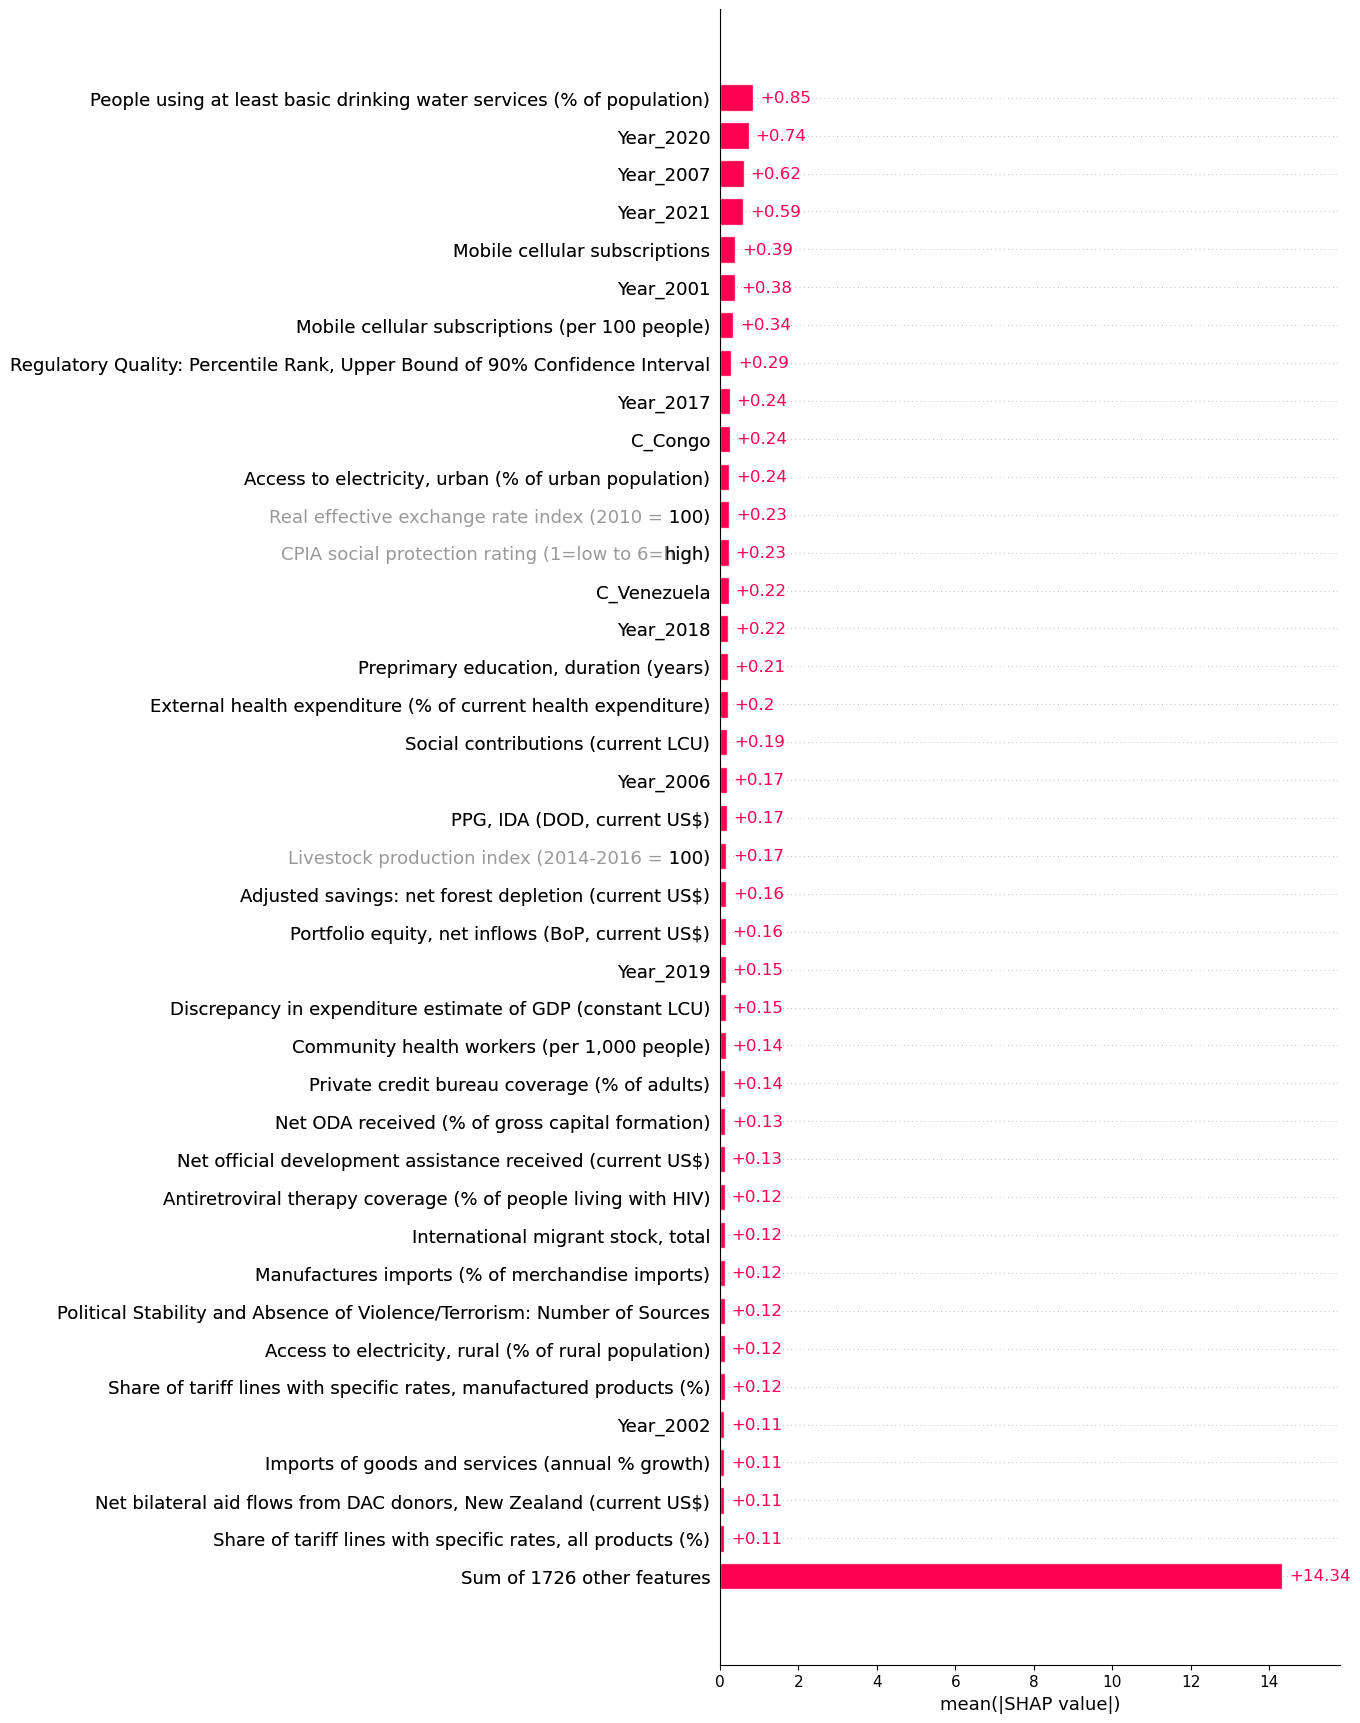

In [200]:
shap.plots.bar(shap_values, max_display=40)